#Importing libraries

In [57]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import string
import re
import math

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import tokenize

#sci-kit learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Loading and inspecting tweets datasets

In [58]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [59]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [60]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [61]:
print(f'Training Set format: {train_df.shape}')
print(f'Test Set format: {test_df.shape}')

Training Set format: (7613, 5)
Test Set format: (3263, 4)


Now let's get an idea about the distribution of 'target' column values across train dataset:
<ul><li>1:disaster tweet</li><li>0: Non-disaster tweet</li></ul>

In [62]:
print(f"the number of tweets about a disaster: {(train_df['target'] == 1).sum()}")
print(f"the number of tweets which aren't about a disaster: {(train_df['target'] == 0).sum()}")
print(f"disaster tweets represent {round((train_df.target.value_counts()[1]/train_df.shape[0])*100)}% of the tweets in the training dataset.")
print(f"Non-disaster tweets represent {round((train_df.target.value_counts()[0]/train_df.shape[0])*100)}% of the tweets in the training dataset.")

the number of tweets about a disaster: 3271
the number of tweets which aren't about a disaster: 4342
disaster tweets represent 43% of the tweets in the training dataset.
Non-disaster tweets represent 57% of the tweets in the training dataset.


#Preprocessing 'text' column

##Lower casing

In [63]:
train_df['text'] = train_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()

##Removing punctuation

In [64]:
punctuations = list(string.punctuation)
print(punctuations)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [65]:
train_df['text'] = train_df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
test_df['text'] = test_df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

In [66]:
train_df['text']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610    m194 0104 utc5km s of volcano hawaii httptcozd...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

##Identifying and removing stop words ("a", "he", "did"...)

Removal of stopwords is necessary since they add noise without having any informational value in modeling.

In [67]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [68]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
train_df['text'] = train_df['text'].apply(lambda x: remove_stopwords(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_stopwords(x))

##Tokenizing text




####Breaking down the text into individual units called tokens, they can be words, phrases ....

In [69]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [70]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens
train_df['tokenized_text'] = train_df['text'].apply(tokenize_text)
test_df['tokenized_text'] = test_df['text'].apply(tokenize_text)

In [71]:
train_df['tokenized_text'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [13000, people, receive, wildfires, evacuation...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: tokenized_text, dtype: object

##Word lemmatizing

####reducing words to their base or root form, known as the lemma. ("running" --> "run", "better" --> "good").

In [72]:
nltk.download('wordnet')
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatize_word(token) for token in tokens]
    return ' '.join(lemmatized_tokens)
train_df['lemmatized_text'] = train_df['text'].apply(lemmatize_text)
test_df['lemmatized_text'] = test_df['text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [73]:
test_df.head()

,id,keyword,location,text,tokenized_text,lemmatized_text
0,0,NaN,NaN,happened terrible car crash,"[happened, terrible, car, crash]",happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...,"[heard, earthquake, different, cities, stay, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...,"[forest, fire, spot, pond, geese, fleeing, acr...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires,"[apocalypse, lighting, spokane, wildfires]",apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan,"[typhoon, soudelor, kills, 28, china, taiwan]",typhoon soudelor kill 28 china taiwan


#Data exploration

## <strong>target</strong> distribution

In [74]:
#Checking the distribution of binary classes (1:tweet about disaster, 0:not)
print(f"the number of disaster tweets: {(train_df['target'] == 1).sum()}")
print(f"the number of non-disaster tweets: {(train_df['target'] == 0).sum()}")
print(f"disaster tweets represent {round((train_df.target.value_counts()[1]/train_df.shape[0])*100)}% of the tweets in the training dataset.")
print(f"Non-disaster tweets represent {round((train_df.target.value_counts()[0]/train_df.shape[0])*100)}% of the tweets in the training dataset.")

the number of disaster tweets: 3271
the number of non-disaster tweets: 4342
disaster tweets represent 43% of the tweets in the training dataset.
Non-disaster tweets represent 57% of the tweets in the training dataset.


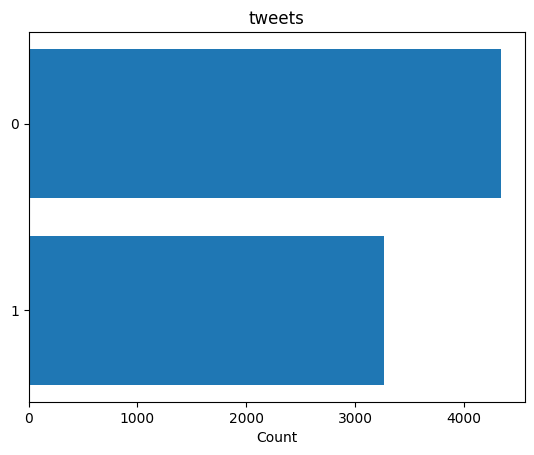

In [75]:
#Visualising the tweets distribution
objects = ('1', '0')
y_pos = np.arange(len(objects))
counts = [(train_df['target'] == 1).sum(), (train_df['target'] == 0).sum()]

plt.barh(y_pos, counts, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Count')
plt.title('tweets')

plt.show()

##Missing values

In [76]:
#Looking for missing values
train_df.isnull().sum()

id                    0
keyword              61
location           2533
text                  0
target                0
tokenized_text        0
lemmatized_text       0
dtype: int64

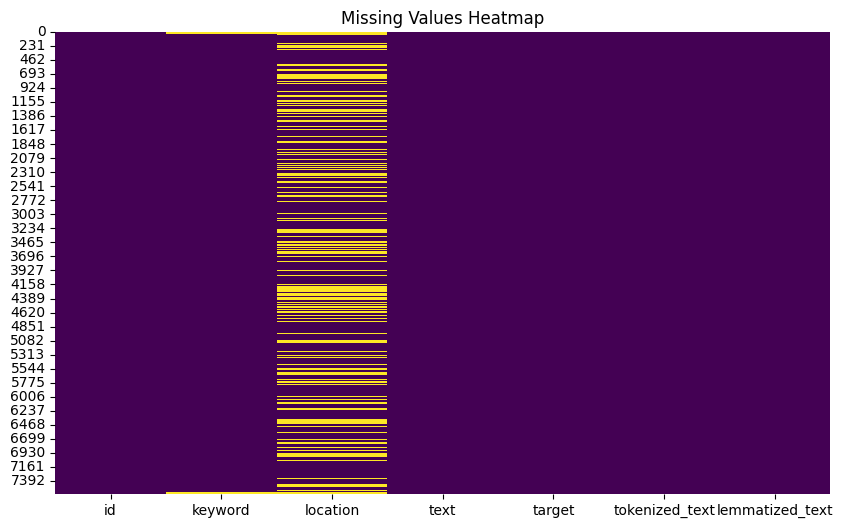

In [77]:
#Visualising missing values using a heatmap
missing_values = train_df.isnull()

# Plot a heatmap to visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(missing_values, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

##Exploring <strong>location</strong> column

The number of unique locations: 3342


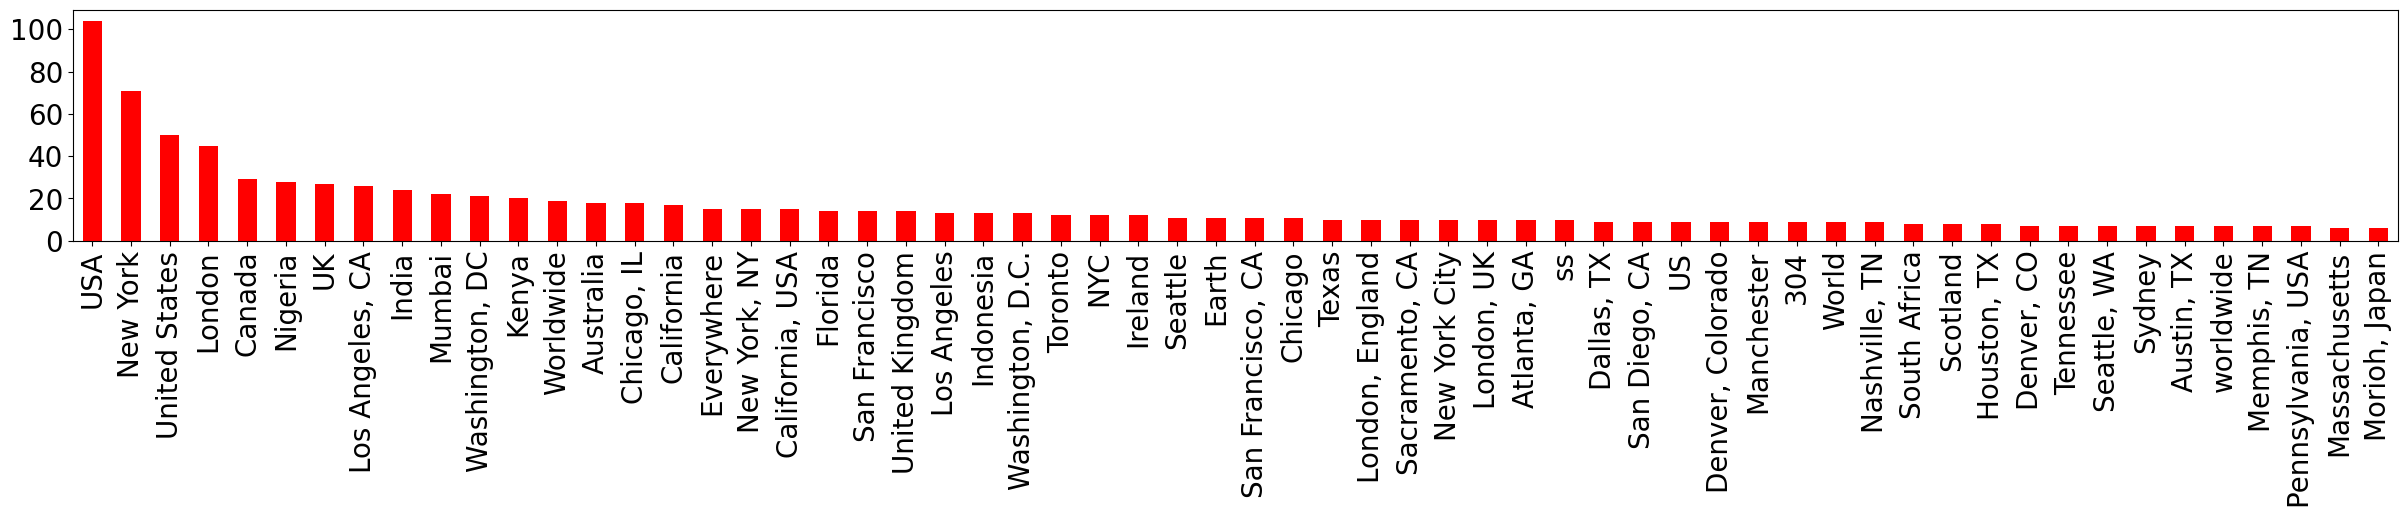

In [78]:
print(f"The number of unique locations: {len(train_df.location.unique())}")
#the distribution of location values
plt.figure(figsize=(30,3))
train_df.location.value_counts().head(60).plot(kind='bar',color='red',fontsize=20)
plt.show()

As we can see from the distribution graphe some location values represent the same thing ("New York, NY" and "NYC").In addition to this some locations include the state and others don't, this might just add noise to our predictions so we could consider dorpping this column.

##Exploring <strong>keywords</strong> column

In [79]:
print(f"Missing values percentage in keyword column: {(train_df['keyword'].isnull().sum()/train_df.shape[0])*100}%")
print(f"Missing values percentage in keyword column for disaster tweets: {(train_df['keyword'][train_df['target'] == 1].isnull().sum()/train_df.shape[0])*100}%")
print(f"Missing values percentage in keyword column for Non-disaster tweets: {(train_df['keyword'][train_df['target'] == 0].isnull().sum()/train_df.shape[0])*100}%")

Missing values percentage in keyword column: 0.8012610009194797%
Missing values percentage in keyword column for disaster tweets: 0.5516879022724287%
Missing values percentage in keyword column for Non-disaster tweets: 0.2495730986470511%


Since missing values only represent 0.8% of the data so we can just drop theim and this wouldn't affect our models prediction that much.

In [80]:
train_df.dropna(subset = "keyword", inplace = True)


###Visualzing <strong>keywords</strong> distribution

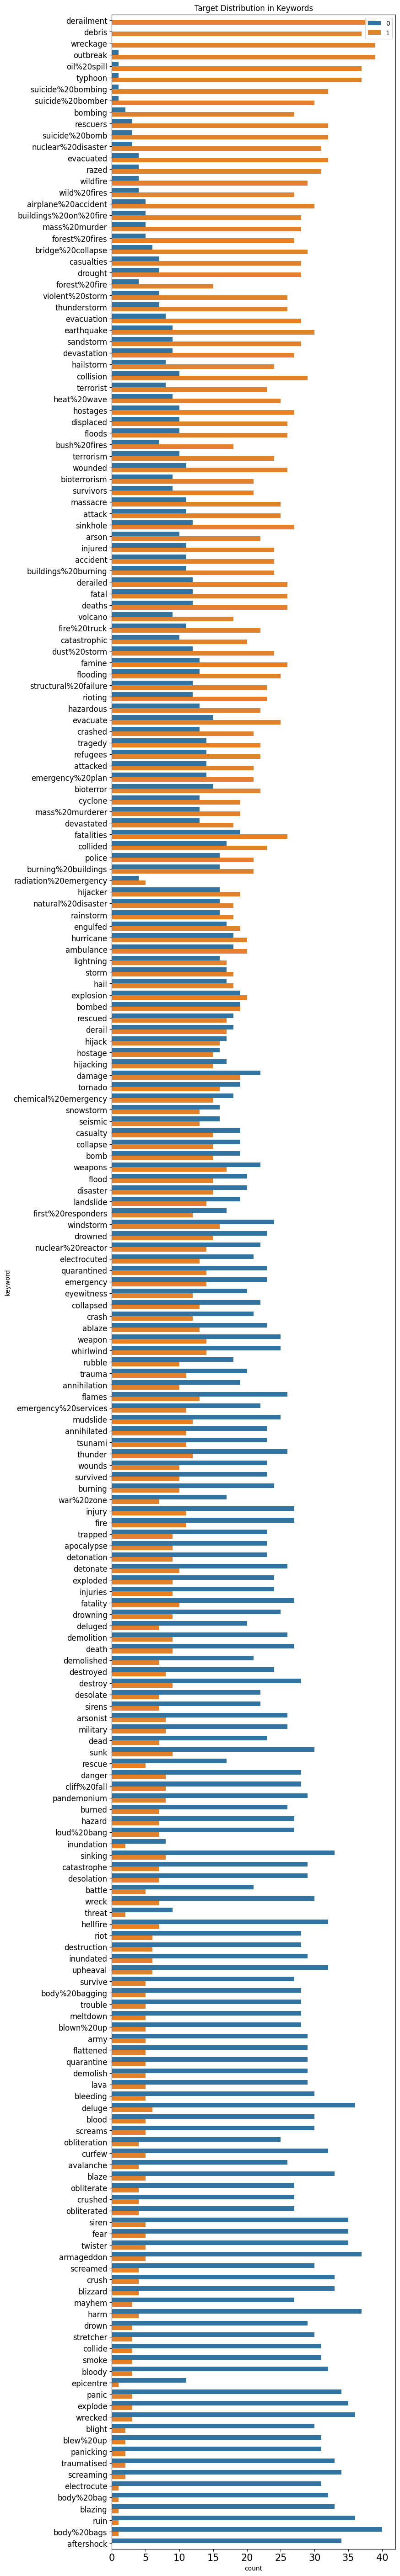

In [81]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_df.drop(columns=['target_mean'], inplace=True)

In [82]:
train_df.head()

,id,keyword,location,text,target,tokenized_text,lemmatized_text
31,48,ablaze,Birmingham,bbcmtd wholesale markets ablaze httptcolhyxeohy6c,1,"[bbcmtd, wholesale, markets, ablaze, httptcolh...",bbcmtd wholesale market ablaze httptcolhyxeohy6c
32,49,ablaze,Est. September 2012 - Bristol,always try bring heavy metal rt httptcoyao1e0xngw,0,"[always, try, bring, heavy, metal, rt, httptco...",always try bring heavy metal rt httptcoyao1e0xngw
33,50,ablaze,AFRICA,africanbaze breaking newsnigeria flag set abla...,1,"[africanbaze, breaking, newsnigeria, flag, set...",africanbaze breaking newsnigeria flag set abla...
34,52,ablaze,"Philadelphia, PA",crying set ablaze,0,"[crying, set, ablaze]",cry set ablaze
35,53,ablaze,"London, UK",plus side look sky last night ablaze httptcoqq...,0,"[plus, side, look, sky, last, night, ablaze, h...",plus side look sky last night ablaze httptcoqq...


### Splitting the data

In [83]:
from sklearn.model_selection import train_test_split
train_df['combined_text'] = train_df['keyword'] + ' ' + train_df['lemmatized_text']
X = train_df["combined_text"]
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X

31      ablaze bbcmtd wholesale market ablaze httptcol...
32      ablaze always try bring heavy metal rt httptco...
33      ablaze africanbaze breaking newsnigeria flag s...
34                                  ablaze cry set ablaze
35      ablaze plus side look sky last night ablaze ht...
                              ...                        
7578               wrecked jtruff23 cameronhacker wrecked
7579    wrecked three day work theyve pretty much wrec...
7580    wrecked fx forex trading cramer igers 3 word w...
7581    wrecked engineshed great atmosphere british li...
7582    wrecked cramer igers 3 word wrecked disney sto...
Name: combined_text, Length: 7552, dtype: object

In [84]:
print(X_train.shape)
print(X_test.shape)

(6041,)
(1511,)


##Feature extraction

In [85]:
# Train Bag of Words model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

##Models Training and Evaluation



In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

In [87]:
models = {"LogisticRegression":LogisticRegression(),
          "KNN":KNeighborsClassifier(n_neighbors = 3),
          "RandomForestClassifier":RandomForestClassifier(),
          "LinearSVC":LinearSVC(),
          "xgb":XGBClassifier()
          }
results = {}

In [88]:
np.random.seed(42)
for model_name, model in models.items():
    model.fit(X_train_vec, y_train)
    results[model_name] = model.score(X_test_vec, y_test)


results_df = pd.DataFrame(results.values(),
                          results.keys(),
                          columns = ['accuracy'])
results_df

,accuracy
LogisticRegression,0.782263
KNN,0.733289
RandomForestClassifier,0.784911
LinearSVC,0.786896
xgb,0.770351


### Hyperparameter tuning

In [89]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],               # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]                   # Whether bootstrap samples are used when building trees
}

# Create an instance of RandomForestClassifier
rf = RandomForestClassifier()

# Create RandomizedSearchCV object
rs_rf = RandomizedSearchCV(estimator=rf,
                           param_distributions=param_grid,
                           cv=5,
                           n_iter=5,  # Set the number of iterations
                           random_state=42)
rs_rf.fit(X_train_vec, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42)

In [90]:
#The best hyperparameters choice
best_params = rs_rf.best_params_
best_model = rs_rf.best_estimator_
# Make predictions with the best model
y_pred = best_model.predict(X_test_vec)

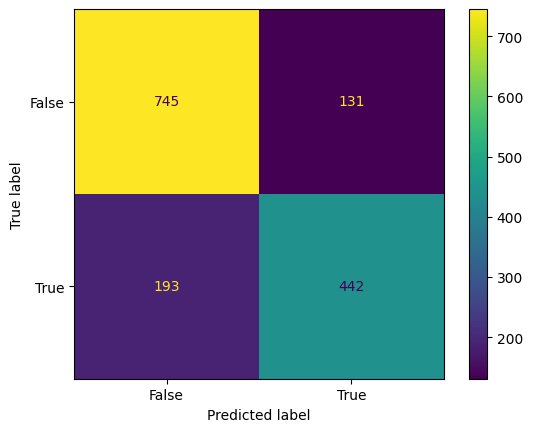

In [91]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
import matplotlib.pyplot as plt
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

In [92]:
clf_report = classification_report(y_test, y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       876
           1       0.77      0.70      0.73       635

    accuracy                           0.79      1511
   macro avg       0.78      0.77      0.78      1511
weighted avg       0.78      0.79      0.78      1511



In [93]:
f1_score = f1_score(y_test, y_pred)
print(f1_score)

0.7317880794701986


In [94]:
import joblib
model_filename = "trained r_forest_model.joblib"
joblib.dump(best_model, model_filename)

['trained r_forest_model.joblib']

In [95]:
#test_df.dropna(subset = ['keyword'], inplace = True)
test_df['combined_text'] = test_df['keyword'] + ' ' + test_df['lemmatized_text']

In [97]:
x_test = test_df['lemmatized_text']
X_train_vec = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(x_test)

In [98]:
loaded_model = joblib.load(model_filename)
y_predd = loaded_model.predict(X_test)

In [99]:
#  submission file
sub = pd.read_csv('sample_submission.csv')
submission_df = pd.DataFrame({'id': sub['id'], 'target': y_predd})
submission_df.to_csv('submission.csv', index=False)